In [1]:
!wget https://raw.githubusercontent.com/davidesonno/diffusion-models-notebooks/main/utils.py

import utils

--2025-05-22 16:42:10--  https://raw.githubusercontent.com/davidesonno/diffusion-models-notebooks/main/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7302 (7.1K) [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]   7.13K  --.-KB/s    in 0s      

2025-05-22 16:42:11 (74.8 MB/s) - ‘utils.py’ saved [7302/7302]



In [2]:
import zipfile
import io
from PIL import Image

def extract_images_from_zip(zip_path):
    image_dict = {}
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        for file_path in zip_ref.namelist():
            if file_path.lower().endswith((".jpg", ".jpeg", ".png")) and '/' in file_path:
                role, filename = file_path.split('/', 1)
                with zip_ref.open(file_path) as file:
                    image = Image.open(file).convert('RGB')
                    if role not in image_dict:
                        image_dict[role] = {}
                    image_dict[role][filename] = image
    return image_dict

def caption_images(image_dict, processor, model, conditional_captioning_text: str = None, device: str = "cuda"):
    model.eval()
    caption_dict = {}
    device = torch.device(device if torch.cuda.is_available() else "cpu")
    model.to(device)

    for subject, images in image_dict.items():
        filenames = list(images.keys())
        pil_images = list(images.values())

        if conditional_captioning_text:
            inputs = processor(pil_images, [conditional_captioning_text] * len(pil_images), return_tensors="pt", padding=True).to(device)
        else:
            inputs = processor(pil_images, return_tensors="pt", padding=True).to(device)

        outputs = model.generate(**inputs)
        captions = processor.batch_decode(outputs, skip_special_tokens=True)
        caption_dict[subject] = {filename: caption for filename, caption in zip(filenames, captions)}

    return caption_dict

In [3]:
import matplotlib.pyplot as plt
import textwrap

def plot_image_dict(image_dict, labels=None, max_per_key=None):
    num_rows = len(image_dict)
    max_cols = max(len(images) for images in image_dict.values())
    ncols = min(max_cols, max_per_key) if max_per_key is not None else max_cols

    fig, axes = plt.subplots(nrows=num_rows, ncols=ncols, figsize=(ncols * 2.5, num_rows * 2.5))

    if num_rows == 1:
        axes = [axes]
    if ncols == 1:
        axes = [[ax] if not isinstance(ax, list) else ax for ax in axes]

    for row_idx, (subject, images) in enumerate(image_dict.items()):
        image_items = list(images.items())
        if max_per_key is not None:
            image_items = image_items[:max_per_key]

        for col_idx in range(ncols):
            ax = axes[row_idx][col_idx]
            if col_idx < len(image_items):
                name, img = image_items[col_idx]
                ax.imshow(img)
                title_text = labels[subject][name] if labels is not None else name
                wrapped_title = "\n".join(textwrap.wrap(title_text, width=35))
                ax.set_title(wrapped_title, fontsize=8)
            ax.axis('off')

        axes[row_idx][0].set_ylabel(subject, fontsize=12, rotation=0, labelpad=40)

    plt.tight_layout()
    plt.show()

In [4]:
zip_path = "sd-legacy_stable-diffusion-v1-5.zip"
images = extract_images_from_zip(zip_path)
images

{'CEO': {'CEO_var1_1.jpg': <PIL.Image.Image image mode=RGB size=512x512>,
  'CEO_var2_1.jpg': <PIL.Image.Image image mode=RGB size=512x512>,
  'CEO_var3_1.jpg': <PIL.Image.Image image mode=RGB size=512x512>},
 'student': {'student_var1_1.jpg': <PIL.Image.Image image mode=RGB size=512x512>,
  'student_var2_1.jpg': <PIL.Image.Image image mode=RGB size=512x512>,
  'student_var3_1.jpg': <PIL.Image.Image image mode=RGB size=512x512>},
 'pharmacist': {'pharmacist_var1_1.jpg': <PIL.Image.Image image mode=RGB size=512x512>,
  'pharmacist_var2_1.jpg': <PIL.Image.Image image mode=RGB size=512x512>,
  'pharmacist_var3_1.jpg': <PIL.Image.Image image mode=RGB size=512x512>}}

In [16]:
import torch
from transformers import AutoProcessor, AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained("MiaoshouAI/Florence-2-large-PromptGen-v2.0", trust_remote_code=True).to("cuda")
processor = AutoProcessor.from_pretrained("MiaoshouAI/Florence-2-large-PromptGen-v2.0", trust_remote_code=True)

In [8]:
def run_on_image_dict(image_dict, model, processor, task_prompt, text_input=None):
    results = {}

    for label, image_set in image_dict.items():
        results[label] = {}
        for filename, image in image_set.items():
            if text_input is None:
                prompt = task_prompt
            else:
                prompt = task_prompt + text_input

            inputs = processor(text=prompt, images=image, return_tensors="pt").to('cuda')
            generated_ids = model.generate(
                input_ids=inputs["input_ids"].cuda(),
                pixel_values=inputs["pixel_values"].cuda(),
                max_new_tokens=1024,
                early_stopping=False,
                do_sample=False,
                num_beams=3,
            )
            generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
            parsed_answer = processor.post_process_generation(
                generated_text,
                task=task_prompt,
                image_size=(image.width, image.height)
            )

            results[label][filename] = parsed_answer[task_prompt]

    return results


In [24]:
labels = run_on_image_dict(images, model, processor, task_prompt="<ANALYZE>", text_input=None)

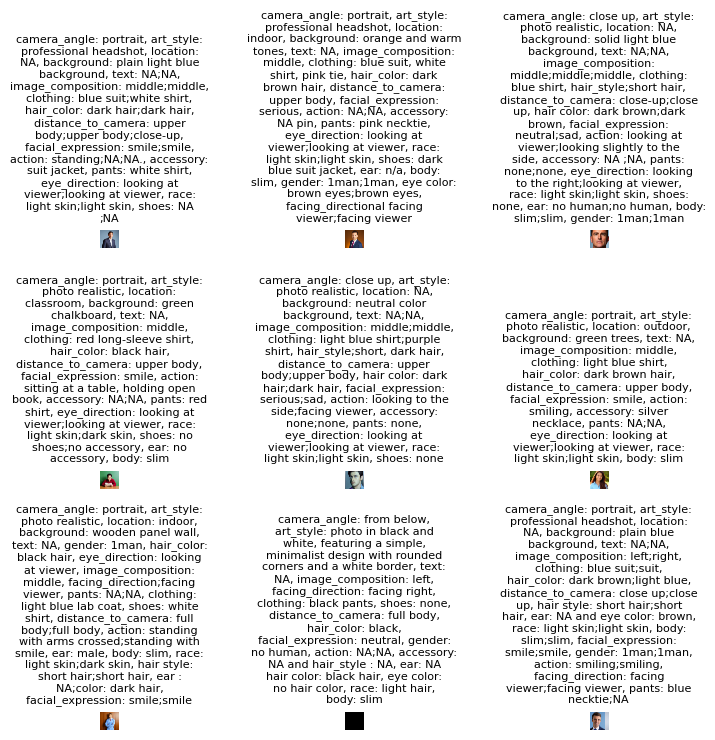

In [25]:
plot_image_dict(images, labels=labels)

In [26]:
labels


{'CEO': {'CEO_var1_1.jpg': 'camera_angle: portrait, art_style: professional headshot, location: NA, background: plain light blue background, text: NA;NA, image_composition: middle;middle, clothing: blue suit;white shirt, hair_color: dark hair;dark hair, distance_to_camera: upper body;upper body;close-up, facial_expression: smile;smile, action: standing;NA;NA., accessory: suit jacket, pants: white shirt, eye_direction: looking at viewer;looking at viewer, race: light skin;light skin, shoes: NA ;NA',
  'CEO_var2_1.jpg': 'camera_angle: portrait, art_style: professional headshot, location: indoor, background: orange and warm tones, text: NA, image_composition: middle, clothing: blue suit, white shirt, pink tie, hair_color: dark brown hair, distance_to_camera: upper body, facial_expression: serious, action: NA;NA, accessory: NA pin, pants: pink necktie, eye_direction: looking at viewer;looking at viewer, race: light skin;light skin, shoes: dark blue suit jacket, ear: n/a, body: slim, gender